In [62]:
import yaml
import sys, os

from IPython.display import Image, SVG

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from src.utils import *
from src.svg_quality_checks import *
from src.gpt_wrappers import *
from src.langchain_database import *

# show svg 
def show_svg(file):
    display(SVG(file))

# load yaml config
with open("../config.yml", "r") as f:
    config = yaml.safe_load(f)

In [63]:
import openai
import wandb

openai.api_key = config["OPENAI_KEY"]
os.environ["OPENAI_API_KEY"] = config["OPENAI_KEY"]

# run = wandb.init(
#     project=config['WANDB_PROJECT'], 
#     entity=config['WANDB_ENTITY']
# )

# results_table = wandb.Table(
#     columns=[
#                 "system_prompt", 
#                 "question_prompt",
#                 "input_svg",
#                 "output_svg",
#                 "input_svg_code",
#                 "output_svg_code",
#                 "valid_check",
#                 "size_check"
#     ]
# )

In [64]:
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAIChat
from langchain.chains.qa_with_sources import load_qa_with_sources_chain

## Create OpenAI index
download the data in separate folders in the "training_data_raw folder"

i.e. "training_data_raw/Footer" ...

In [65]:
sources = create_sources_from_files(path = "../training_data_raw/", 
                                    description = "SVG for", 
                                    style = ""
                                    )
chunks = create_chunks_from_the_sources(sources, 
                                        separators = [], 
                                        chunk_size = 1024, 
                                        chunk_overlap = 0
                                        )
index = create_index_from_the_chunks(chunks)

# Running experiments

## Case 1: no SVG input

In [78]:
system_prompt = \
"""
    You are an expert in design in different fields, you use different vector graphics tools.
    You deal professionally with SVG files, you know how to create complex design with them.
    Your main jon is to complete design systems and tokens based on the initial inputs. 
    These initial inputs are SVG files that can consist of multiple layers, groups, paths, etc.
    They can be different elements as icons, logos, buttons, checkboxes, etc. \n
"""

question_prompt = \
"""=========
TASK:
Generate SVG of {question}.
Keep it as short and optimized as you can, be limited by the tokens.
Start with <svg ... and end with </svg>.
=========
SIMILAR ELEMENTS:
{summaries}
=========
SVG:"""

template = system_prompt + question_prompt

prompt = PromptTemplate(template=template, input_variables=["summaries", "question"])
chain = load_qa_with_sources_chain(OpenAIChat(temperature=0.0, model_name="gpt-3.5-turbo"), prompt=prompt)

question = "Green magnifying glass icon, 50 x 50 px"

answer = chain(
            {
                "input_documents": index.similarity_search(question, k=4),
                "question": question,
            },
            return_only_outputs=True,
        )["output_text"]

print(answer)
print("Quality check:", validate_svg(answer), get_svg_size(answer))

<svg xmlns="http://www.w3.org/2000/svg" width="50" height="50" viewBox="0 0 50 50">
  <path d="M22.5 0C10.1 0 0 10.1 0 22.5S10.1 45 22.5 45 45 34.9 45 22.5 34.9 0 22.5 0zm0 41.7c-9.7 0-17.6-7.9-17.6-17.6S12.8 6.5 22.5 6.5 40.1 14.4 40.1 24.1 32.2 41.7 22.5 41.7z" fill="#0F0"/>
  <path d="M35.3 35.3L50 50" stroke="#0F0" stroke-width="5"/>
</svg>
Quality check: True (50.0, 50.0)


In [79]:
index.similarity_search(question, k=4)

[Document(page_content='d="m50.00,0.00h50.00v50.00H50.00z" fill="#6750.00a4.00" /></g><g><path d="m50.00,50.00v50.00h50.00V50.00z" fill="#6750.00a4.00" /></g></g></g></svg>', metadata={'source': '../training_data_raw/components_clean/Circular_50%_Progress_Indicator.svg', 'name': 'Circular_50%_Progress_Indicator', 'style': 'style'}),
 Document(page_content='d="m50.00,0.00h50.00v50.00H50.00z" fill="#6750.00a4.00" /></g><g><path d="m50.00,50.00v50.00h50.00V50.00z" fill="#6750.00a4.00" /></g><g><path d="m0.00,50.00v50.00h50.00V50.00z" fill="#6750.00a4.00" /></g></g></g></svg>', metadata={'source': '../training_data_raw/components_clean/Circular_75%_Progress_Indicator.svg', 'name': 'Circular_75%_Progress_Indicator', 'style': 'style'}),
 Document(page_content='clip-path="url(#f)"><g><path d="m50.00,0.00v50.00h50.00V0.00z" fill="#6750.00a4.00" /></g></g></g></svg>', metadata={'source': '../training_data_raw/components_clean/Circular_25%_Progress_Indicator.svg', 'name': 'Circular_25%_Progress_


test_optimized.svg:
Done in 26 ms!
0.306 KiB - 9.9% = 0.275 KiB


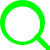

In [80]:
FILENAME = 'test'
save_gpt_answer_as_svg(answer, FILENAME)
show_svg(f'../generated_data/{FILENAME}_optimized.svg')

In [69]:
# results_table.add_data(
#     *[
#         system_prompt, question, 
#         wandb.Html(f'../generated_data/{FILENAME}_optimized.svg'), wandb.Html(f'../generated_data/{FILENAME}_optimized.svg'),
#         "", answer,
#         validate_svg(answer), get_svg_size(answer)
#     ]
# )

## Case 2: SVG input


segmented_buttons_short_optimized.svg:
Done in 91 ms!
13.162 KiB - 70.3% = 3.909 KiB


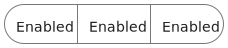

In [70]:
FILENAME = "segmented_buttons_short"
svg_original = load_raw_svg_optimize_clean(FILENAME)
show_svg(f'../data/svgs/{FILENAME}_optimized.svg')

In [71]:
system_prompt = \
"""
    You are an expert in design in different fields, you use different vector graphics tools.
    You deal professionally with SVG files, you know how to create complex design with them.
    Your main jon is to complete design systems and tokens based on the initial inputs. 
    These initial inputs are SVG files that can consist of multiple layers, groups, paths, etc.
    They can be different elements as icons, logos, buttons, checkboxes, etc. \n
"""

question_prompt = \
"""=========
TASK:
Generate SVG of {question}.
Keep it as short and optimized as you can, be limited by the tokens.
Start with <svg ... and end with </svg>.
=========
SIMILAR ELEMENTS:
{summaries}
=========
SVG:"""

template = system_prompt + question_prompt

prompt = PromptTemplate(template=template, input_variables=["summaries", "question"])
chain = load_qa_with_sources_chain(OpenAIChat(temperature=0.9, model_name="gpt-3.5-turbo"), prompt=prompt)

question = f"Segmented buttons the same as in the following SVG but middle button is green {svg_original}"

answer = chain(
            {
                "input_documents": index.similarity_search(question, k=2),
                "question": question,
            },
            return_only_outputs=True,
        )["output_text"]

print(answer)
print("Quality check:", validate_svg(answer), get_svg_size(answer))

KeyboardInterrupt: 

In [ ]:
save_gpt_answer_as_svg(answer, FILENAME)
show_svg(f'../generated_data/{FILENAME}_optimized.svg')

ParseError: unclosed token: line 58, column 12 (<string>)

In [ ]:
# results_table.add_data(
#     *[
#         system_prompt, question, 
#         wandb.Html(f'../data/svgs/{FILENAME}_optimized.svg'), wandb.Html(f'../generated_data/{FILENAME}_optimized.svg'),
#         svg_original, answer,
#         validate_svg(answer), get_svg_size(answer)
#     ]
# )

## Log everything

In [ ]:
# run.log({"results_table": results_table})